In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torch.nn as nn
import torch.optim as optim
import sys

sys.path.insert(0, '../src')
from bird_dataset import *
from XAI_birds_dataloader import *

In [2]:
from tqdm import tqdm

In [3]:
bd = BirdDataset()

In [4]:
bd.attributes

{1: 'has_bill_shape::curved_(up_or_down)',
 2: 'has_bill_shape::dagger',
 3: 'has_bill_shape::hooked',
 4: 'has_bill_shape::needle',
 5: 'has_bill_shape::hooked_seabird',
 6: 'has_bill_shape::spatulate',
 7: 'has_bill_shape::all-purpose',
 8: 'has_bill_shape::cone',
 9: 'has_bill_shape::specialized',
 10: 'has_wing_color::blue',
 11: 'has_wing_color::brown',
 12: 'has_wing_color::iridescent',
 13: 'has_wing_color::purple',
 14: 'has_wing_color::rufous',
 15: 'has_wing_color::grey',
 16: 'has_wing_color::yellow',
 17: 'has_wing_color::olive',
 18: 'has_wing_color::green',
 19: 'has_wing_color::pink',
 20: 'has_wing_color::orange',
 21: 'has_wing_color::black',
 22: 'has_wing_color::white',
 23: 'has_wing_color::red',
 24: 'has_wing_color::buff',
 25: 'has_upperparts_color::blue',
 26: 'has_upperparts_color::brown',
 27: 'has_upperparts_color::iridescent',
 28: 'has_upperparts_color::purple',
 29: 'has_upperparts_color::rufous',
 30: 'has_upperparts_color::grey',
 31: 'has_upperparts_col

In [5]:
class Wing_Color_Loader(XAI_Birds_Dataset):
    '''
    Can be combined with Bill Shape Class into one general class with attribute self.attr = 'has_wing_color'
    '''
    def __init__(self, bd:BirdDataset, subset=True, transform=None, train=True, val=False, random_seed=42):
        XAI_Birds_Dataset.__init__(self, bd, subset=subset, transform=transform, train=train, val=val, random_seed=random_seed)
        
        self.class_dict = self._set_classes_bill_shape()
        self.images, self.bill_shape_indices = self._filter_images_bill_shape()
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = os.path.join(self.bd.img_dir, self.images[idx]['filepath'])
        image = Image.open(img_path)
        bill_shape = self.images[idx]['attributes'][self.bill_shape_indices[idx]]
        label = self.class_dict[bill_shape]
        sample = {'image': image, 'label':label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample
    
    def _set_classes_bill_shape(self):
        pd_attr = pd.Series(self.bd.attributes)
        bill_shape_dict = pd_attr[pd_attr.str.contains('has_wing_color')].to_dict()
        class_dict = dict(zip(bill_shape_dict.values(), range(len(bill_shape_dict))))
        return class_dict
    
    def _filter_images_bill_shape(self):
        filt_images = []
        bill_shape_indices = []
        for img in self.images:
            for idx, attr in enumerate(img['attributes']):
                if 'has_wing_color' in attr:
                    filt_images.append(img)
                    bill_shape_indices.append(idx)
                    break
        return filt_images, bill_shape_indices

In [6]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = Wing_Color_Loader(bd, transform=trans, train=True)
val_bird_dataset = Wing_Color_Loader(bd, transform=trans, train=False, val=True)

In [10]:
labels = []
for i in tqdm(range(len(train_bird_dataset))):
    labels.append(train_bird_dataset[i]['label'])

100%|██████████| 1362/1362 [02:41<00:00,  8.45it/s]


In [11]:
inv_class_dict = {v : k for k, v in train_bird_dataset.class_dict.items()}

In [15]:
pd.Series(data=[inv_class_dict[i] for i in labels]).value_counts()#.to_csv('wing_color_train_counts.csv')

has_wing_color::black         550
has_wing_color::brown         230
has_wing_color::grey          206
has_wing_color::blue          118
has_wing_color::yellow         88
has_wing_color::red            39
has_wing_color::orange         36
has_wing_color::rufous         34
has_wing_color::olive          17
has_wing_color::buff           14
has_wing_color::green           9
has_wing_color::iridescent      7
has_wing_color::pink            6
has_wing_color::white           4
has_wing_color::purple          4
dtype: int64

In [13]:
val_labels = []
for i in tqdm(range(len(val_bird_dataset))):
    val_labels.append(val_bird_dataset[i]['label'])

100%|██████████| 343/343 [00:41<00:00,  8.33it/s]


In [16]:
pd.Series(data=[inv_class_dict[i] for i in val_labels]).value_counts()#.to_csv('wing_color_val_counts.csv')

has_wing_color::black         140
has_wing_color::grey           61
has_wing_color::brown          51
has_wing_color::blue           26
has_wing_color::yellow         18
has_wing_color::orange         13
has_wing_color::red            10
has_wing_color::rufous          8
has_wing_color::olive           5
has_wing_color::white           5
has_wing_color::pink            2
has_wing_color::green           2
has_wing_color::iridescent      1
has_wing_color::buff            1
dtype: int64

In [17]:
vgg16 = models.vgg16_bn(pretrained=True)
# vgg16

In [18]:
num_feats = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_feats, len(train_bird_dataset.class_dict))])
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier

In [19]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

if torch.cuda.is_available():
    vgg16.cuda()

batch_size = 4
trainloader = DataLoader(train_bird_dataset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_bird_dataset, batch_size=batch_size, shuffle=True)

loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

cuda:0


In [20]:
%%time
avg_losses = []
avg_val_losses = []
epochs = 50
print_freq = 100
val_acc = []
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data['image'], data['label']

        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = vgg16(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
#         print(outputs)
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            running_loss = 0.0
            
    avg_losses.append(avg_loss)
    
    vgg16.eval()
    with torch.no_grad():
        num_correct=0
        val_losses = []
        data_iter = iter(valloader)
        for val_data in data_iter:
            val_inputs, val_labels = val_data['image'].cuda(), val_data['label'].cuda()
#                     print('val inputs: ',val_inputs.size())
#                     print('val labels: ',val_labels)
#                     print('inputs: ',inputs.size())
#             print(val_labels)
            val_outputs = vgg16(val_inputs)
#                     print('val outputs: ',val_outputs)
#                     print('val loss: ',nn.CrossEntropyLoss()(val_outputs, val_labels))
            opt.zero_grad() #zero the parameter gradients
            _, val_predicted = torch.max(val_outputs, 1)
            #     print(predicted)
            # print(labels)
            # print(predicted)
#             num_correct_k += topk_accuracy(k, labels, outputs)
            num_correct += sum(np.array(val_labels.cpu())==np.array(val_predicted.cpu()))
#             print(predicted)
#             print(val_labels)
            val_losses.append(loss_func(val_outputs, val_labels).item())
        acc = num_correct/(len(data_iter)*batch_size)
        val_acc.append(acc)
        print('Validation accuracy:',acc)
        print('Average validation loss:',np.mean(val_losses))
        avg_val_losses.append(np.mean(val_losses))
    vgg16.train()
print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 1.779
[epoch: 0, i:   199] avg mini-batch loss: 1.692
[epoch: 0, i:   299] avg mini-batch loss: 1.586
Validation accuracy: 0.6017441860465116
Average validation loss: 1.1705640651458917
[epoch: 1, i:    99] avg mini-batch loss: 1.234
[epoch: 1, i:   199] avg mini-batch loss: 1.333
[epoch: 1, i:   299] avg mini-batch loss: 1.278
Validation accuracy: 0.6918604651162791
Average validation loss: 1.0336719397888627
[epoch: 2, i:    99] avg mini-batch loss: 0.959
[epoch: 2, i:   199] avg mini-batch loss: 0.951
[epoch: 2, i:   299] avg mini-batch loss: 0.992
Validation accuracy: 0.7674418604651163
Average validation loss: 0.7120144616725833
[epoch: 3, i:    99] avg mini-batch loss: 0.658
[epoch: 3, i:   199] avg mini-batch loss: 0.856
[epoch: 3, i:   299] avg mini-batch loss: 0.951
Validation accuracy: 0.7645348837209303
Average validation loss: 0.8243322341248046
[epoch: 4, i:    99] avg mini-batch loss: 0.607
[epoch: 4, i:   199] avg mini-batch loss

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py", line 1312, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 8, in <module>
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 346, in __next__
    data = self.dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-5-f3d6ced74051>", line 19, in __getitem__
    sample['image'] = self.transform(sample['image'])
  File "/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py", line 61, in __call__
    img = t(img)
  File "/opt/conda/lib/python3.7/site-

KeyboardInterrupt: 

In [21]:
torch.save(vgg16.state_dict(), '../models/transfer_vgg16_wing_color_28_epoch_4_batch.pth')

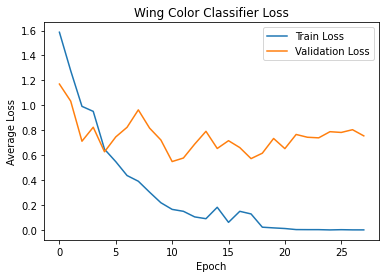

In [23]:
plt.plot(avg_losses)
plt.plot(avg_val_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Wing Color Classifier Loss')
plt.legend(['Train Loss', 'Validation Loss']);
plt.savefig('../figures/train_val_loss_wing_color_28_epoch.png')